# GEODOS data processing

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
import glob
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


## Read Logfile

In [2]:
fto = '/storage/experiments/2021/03_REFLECT3/AirdosCvetsiNaITl_9c/DATALOG.TXT' #  File to Open

l=[]
l.extend(range(0,500))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python' )

df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)

sn = df.loc[df[0]=='$AIRDOS',3]
fw = df.loc[df[0]=='$AIRDOS',2]
last = df.loc[df[0]=='$AIRDOS'].index
print ('s.n.: ',sn[0])
print ('f.v.: ',fw[0])
print(df.loc[df[0]=='$AIRDOS',1])
print(len(df))
print(last[-1:][0])

df.drop(df.index[:last[-1:][0]], inplace=True) # keep only last run

s.n.:  1290c00806a200922457a000a000009c
f.v.:  51832f3
0      GEO1
1      GEO1
625    GEO1
Name: 1, dtype: object
7014
625


## Fill position and time

In [3]:
#df.drop(df.loc[(df[0]=='$GPRMC') & (df[2]=='V')].index, inplace=True)
df['latf'] = pd.to_numeric(df.loc[df[0]=='$GPRMC',3])
df['lonf'] = pd.to_numeric(df.loc[df[0]=='$GPRMC',5])
df['on_miliseconds'] = pd.to_numeric(df.loc[df[0]=='$TIME',1]) * 1000
df['miliseconds'] = pd.to_numeric(df.loc[df[0]=='$HIST',2]) * 1000
df['gps_time'] = df.loc[df[0]=='$GPRMC',1]
df['gps_date'] = df.loc[df[0]=='$GPRMC',9]
df['alt'] = df.loc[df[0]=='$GPGGA',9]
df.loc[(df[0]=='$GPRMC') & (df[6]=='E'),'lon_hem']=1
df.loc[(df[0]=='$GPRMC') & (df[6]=='W'),'lon_hem']=-1
df.loc[(df[0]=='$GPRMC') & (df[4]=='N'),'lat_hem']=1
df.loc[(df[0]=='$GPRMC') & (df[4]=='S'),'lat_hem']=-1
df['lat'] = (np.trunc(df['latf']/100) + (((df['latf']/100) - np.trunc(df['latf']/100)) * 100) / 60.0) * df['lat_hem']
df['lon'] = (np.trunc(df['lonf']/100) + ((df['lonf']/100) - np.trunc(df['lonf']/100)) * 100 / 60.0) * df['lon_hem']  
df['date'] = pd.to_datetime(df['gps_date']+df['gps_time'], format='%d%m%y%H%M%S.%f')#,errors='coerce')
df.drop('lon_hem', axis=1, inplace=True)
df.drop('lat_hem', axis=1, inplace=True)
df.drop('latf', axis=1, inplace=True)
df.drop('lonf', axis=1, inplace=True)
df.drop('gps_time', axis=1, inplace=True)
df.drop('gps_date', axis=1, inplace=True)
df['meas'] = df.loc[df[0]=='$HIST',1]
df = df.fillna(method='ffill')
df.drop(df[df[0]=='$GPGGA'].index, inplace=True)
df.drop(df[df[0]=='$GPRMC'].index, inplace=True)
df.drop(df[df[0]=='$AIRDOS'].index, inplace=True)
df.drop(df[df[0]=='$TIME'].index, inplace=True)
df['UTC'] = df['date'] + pd.to_timedelta(df['miliseconds'], unit='ms') - pd.to_timedelta(df['on_miliseconds'], unit='ms')
df.drop('date', axis=1, inplace=True)
df.drop('miliseconds', axis=1, inplace=True)
df.drop('on_miliseconds', axis=1, inplace=True)
df


,0,1,2,3,4,5,6,7,8,9,...,495,496,497,498,499,alt,lat,lon,meas,UTC
1025,$HIST,89,1252.12,98142.25,18.69,3,65531,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89,NaT
1026,$HITS,0,1252.12,98142.25,18.69,3,65531,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89,NaT
1040,$HIST,90,1271.23,98143.75,18.75,6,65527,1,0,0,...,NaN,NaN,NaN,NaN,NaN,426.4,50.095441,14.282181,90,2021-03-24 10:28:07.380
1041,$HITS,0,1271.23,98143.75,18.75,6,65527,1,0,0,...,NaN,NaN,NaN,NaN,NaN,426.4,50.095441,14.282181,90,2021-03-24 10:28:07.380
1042,$HIST,91,1279.98,98146.25,18.81,5,65529,0,0,0,...,NaN,NaN,NaN,NaN,NaN,426.4,50.095441,14.282181,91,2021-03-24 10:28:16.130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11514,$HITS,6,8702,10,13540,15,54619,10,61436,13,...,NaN,NaN,NaN,NaN,NaN,217.7,50.116139,14.460382,2369,2021-03-24 17:22:14.680
11528,$HIST,2370,26206.35,99317.50,21.63,1,65511,5,3,4,...,NaN,NaN,NaN,NaN,NaN,217.7,50.116139,14.460382,2370,2021-03-24 17:23:39.210
11529,$HITS,3,6565,12,13137,9,114282,10,3,4,...,NaN,NaN,NaN,NaN,NaN,217.7,50.116139,14.460382,2370,2021-03-24 17:23:39.210
11530,$HIST,2371,26215.35,99320.75,21.69,0,65521,3,1,2,...,NaN,NaN,NaN,NaN,NaN,217.7,50.116139,14.460382,2371,2021-03-24 17:23:48.210


## Add individual events to histogram

In [135]:
df.dropna(subset=['UTC'], inplace=True)
hist = df.loc[df[0]=='$HIST'].iloc[:,:270].copy()
hist.iloc[:,1:] = hist.iloc[:,1:].apply(pd.to_numeric) #,errors='coerce')
hist[0] = df[0]
hist['alt'] = df['alt'].apply(pd.to_numeric,errors='coerce')
hist['lat'] = df['lat'].apply(pd.to_numeric,errors='coerce')
hist['lon'] = df['lon'].apply(pd.to_numeric,errors='coerce')
hist['meas'] = df['meas'].apply(pd.to_numeric,errors='coerce')
hist['UTC'] = df['UTC']
hist.iloc[:,12:269] = 0
hist.set_index('meas', inplace=True)
hits = df.loc[df[0]=='$HITS'].copy()
hits.iloc[:,1:] = hits.iloc[:,1:].apply(pd.to_numeric)
hits.set_index('meas', inplace=True)


In [136]:
for index, row in hits.iterrows():
    for j in range(2,2+row[1]*2,2):
        hist.loc[index,int(row[j+1])+3] += 1


## Plot Flux

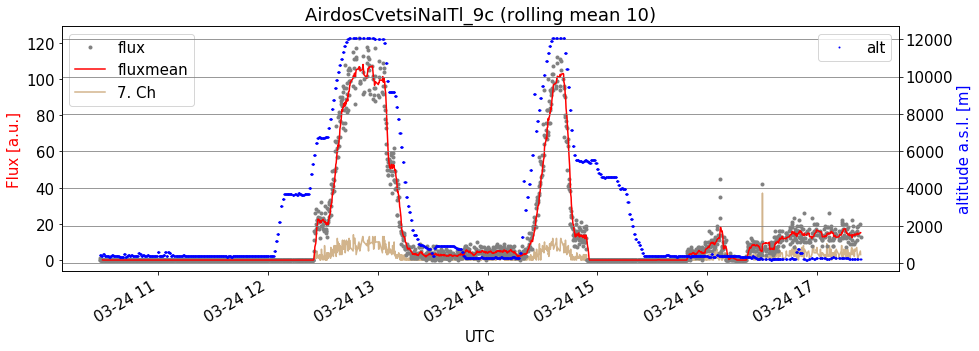

In [137]:
NOISE_LEVEL = 7
LAST_CHANNEL = 270
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = hist
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']


xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

xx['flux'].plot(c='gray', linestyle='', marker='.')
xx['fluxmean'].plot(c='red')
(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Flux [a.u.]', color='red')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['alt'].plot(c='b', label='alt', marker='.', ms=2, linewidth='2', linestyle='none', drawstyle='steps-mid')
plt.ylabel('altitude a.s.l. [m]', color='blue')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



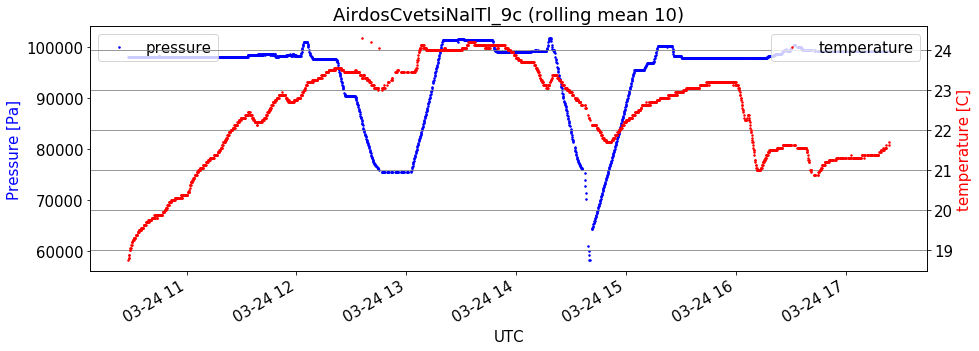

In [138]:
NOISE_LEVEL = 7
LAST_CHANNEL = 270
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = hist
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']



xx[3].plot(c='blue', linestyle='', marker='.', ms=3, label = 'pressure')

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Pressure [Pa]', color='blue')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx[4].plot(c='red', label='temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel('temperature [C]', color='red')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



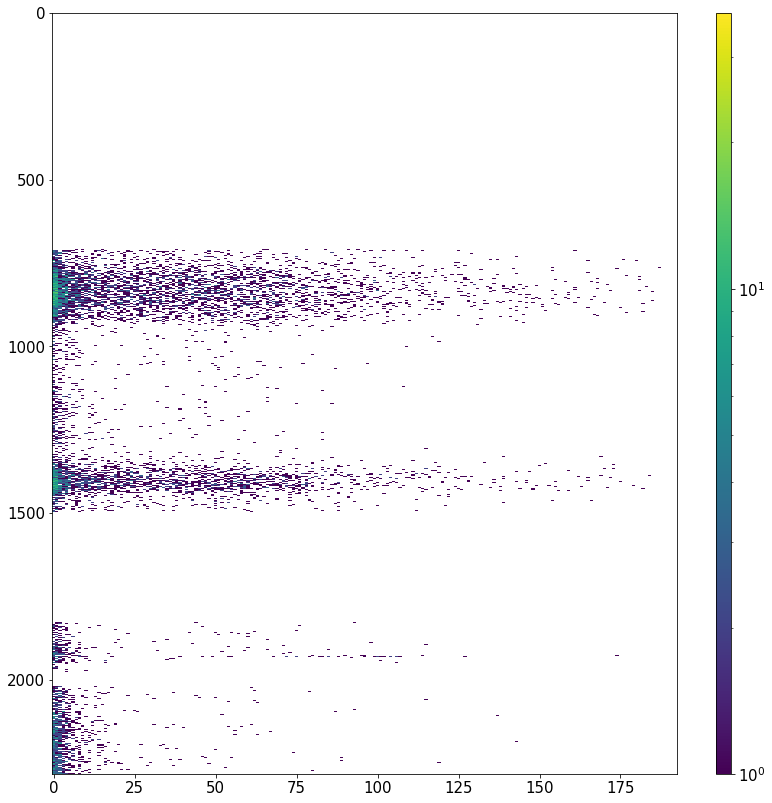

In [145]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(14, 14))
plt.imshow((hist.iloc[:,7:200]), aspect='auto', norm=LogNorm())
plt.colorbar(aspect=50)
None

In [141]:

hist['2021-03-24 13:00:00':'2021-03-24 13:01:00'].iloc[:,7:]


,7,8,9,10,11,12,13,14,15,16,...,266,267,268,269,alt,lat,lon,UTC,flux,fluxmean
UTC,,,,,,,,,,,,,,,,,,,,,
2021-03-24 13:00:19.550,10,6,2,4,3.0,2,1,1,1,0,...,0,0,0,NaN,12037.0,50.257991,15.868048,2021-03-24 13:00:19.550,91.0,97.0
2021-03-24 13:00:29.050,6,8,5,3,5.0,1,1,0,3,3,...,0,0,0,NaN,12037.0,50.257991,15.868048,2021-03-24 13:00:29.050,110.0,98.0
2021-03-24 13:00:38.800,6,7,3,3,3.0,3,4,0,2,0,...,0,0,0,NaN,12037.0,50.257991,15.868048,2021-03-24 13:00:38.800,90.0,98.1
2021-03-24 13:00:48.140,10,7,9,8,3.0,2,3,0,3,2,...,0,0,0,NaN,12037.0,50.257991,15.868048,2021-03-24 13:00:48.140,101.0,98.0
2021-03-24 13:00:57.710,10,8,2,5,4.0,1,2,2,1,1,...,0,0,0,NaN,12037.0,50.257991,15.868048,2021-03-24 13:00:57.710,106.0,99.5
